# Hindcasting with CaSPAr-Archived ECCC forecasts

This notebook shows how to perform a streamflow hindcast, using CaSPar archived weather forecasts. It generates the hindcasts and plots them, then evaluates the skill using verification metrics.

CaSPAr (Canadian Surface Prediction Archive) is an archive of historical ECCC forecasts developed by Juliane Mai at the University of Waterloo, Canada. More details on CaSPAr can be found here https://caspar-data.ca/.


Mai, J., Kornelsen, K.C., Tolson, B.A., Fortin, V., Gasset, N., Bouhemhem, D., Schäfer, D., Leahy, M., Anctil, F. and Coulibaly, P., 2020. The Canadian Surface Prediction Archive (CaSPAr): A Platform to Enhance Environmental Modeling in Canada and Globally. Bulletin of the American Meteorological Society, 101(3), pp.E341-E356.


In [ ]:
%matplotlib inline
# This entire section is cookie-cutter template to allow calling the servers and instantiating the connection
# to the WPS server. Do not modify this block.
from urllib.request import urlretrieve
from birdy import WPSClient
from ravenpy.utilities.testdata import get_file
from pathlib import Path
import json
import os
import datetime as dt
import tempfile
import xarray as xr

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)
tmp = Path(tempfile.mkdtemp())

In [ ]:
# Define some of the catchment properties. Could also be replaced by a call to the properties WPS.
region_vector = str(get_file("watershed_vector/LSJ_LL.zip"))

basin_area = 44523.5
basin_longitude = -72.55
basin_latitude = 48.39
basin_elevation= 300.0

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'GR4JCN'

# Since we've used GR4JCN, we need to provide that model's parameters.
gr4j_parameters = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'

nc_transforms = json.dumps({'tas': {'time_shift': -0.25},
                            'pr': {'time_shift': -0.25, 'deaccumulate':True}})

# Date of the hindcast
hdate = dt.datetime(2018,6,1)

# Duration of the hindcast, in days
duration = 7

# Launch the hydrological realtime forecasting WPS
resp_hind = wps.hindcasting(region_vector=region_vector,
                       latitude=basin_latitude,
                       longitude=basin_longitude,
                       area=basin_area, 
                       elevation=basin_elevation, 
                       forecast_model="GEPS", 
                       hdate=hdate, 
                       gr4jcn=gr4j_parameters,
                       duration=duration, 
                       rvc=str(get_file("gr4j_cemaneige/solution.rvc")), 
                       nc_spec=nc_transforms, 
                       rain_snow_fraction='RAINSNOW_DINGMAN')


In [ ]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy them locally. 
[hydrograph, storage, solution, diagnostics, rv ] = resp_hind.get(asobj=True)

#Since we requested output objects, we can simply access the forecast object needed for later evaluation.
hydrograph = hydrograph.rename_dims({'nbasins':'member'})
hydrograph.to_netcdf(str(tmp) + '/hcst.nc')

### Now, we can compute the hindcast scores such as CRPS for this hindcast using the XSkillScore package:

In [ ]:
qq = hydrograph.isel(member=10)
qq.to_netcdf(str(tmp) + '/q_obs.nc','w')

### Now let's run XSkillScore

In [ ]:
resp = wps.hindcast_evaluation(obs=str(tmp / 'q_obs.nc'), hcst=str(tmp / 'hcst.nc'), obs_var='q_sim', hcst_var='q_sim', metric='crps_ensemble')
[score] = resp.get(asobj=True)
display(score)

{'crps_ensemble': 0.019442274872010164}

### And, for visual representation of the forecasts:

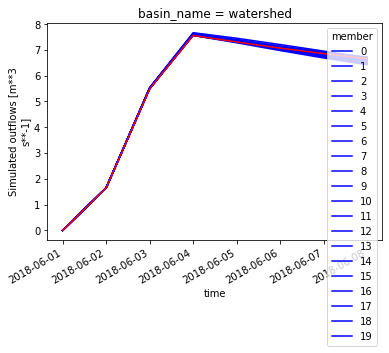

In [ ]:
import matplotlib.pyplot as plt

# This is to be replaced with a call to the forecast graphing WPS as soon as merged.
hydrograph.q_sim.plot.line('b',x='time')
qq.q_sim.plot.line('r')
plt.show()

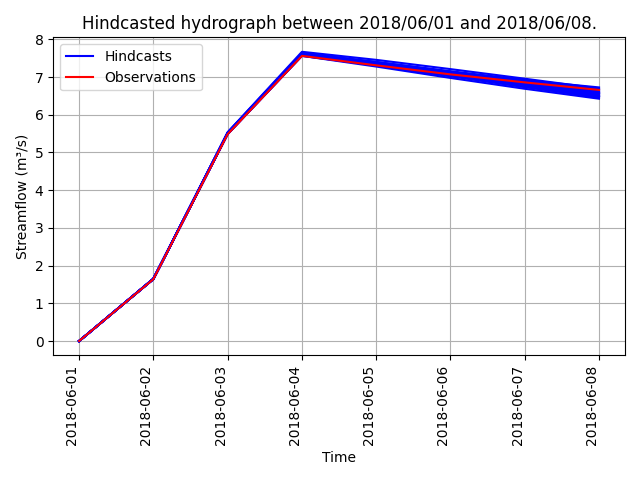

In [ ]:
resp_graph = wps.graph_forecast_uncertainty(qobs=str(tmp / 'q_obs.nc'), fcst=str(tmp / 'hcst.nc'), qobs_var='q_sim', fcst_var='q_sim')
resp_graph.get(asobj=True)[0]